In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import pandas as pd
from scipy import stats

from PIL import Image, ImageStat

/home/mkutuga/anaconda3/envs/semif_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device      = torch.device('cpu') 
batch_size  = 4
image_size = 512
data_path   = '../data/semifield-cutouts/TX_2022-12-21/'


In [3]:
data = list(Path("data/semifield-cutouts/TX_2022-12-21_/").glob("*.png"))
data = sorted([x for x in data if "_mask" not in str(x)])
imgs = [cv2.imread(str(img)) for img in data]
len(data)

66

In [8]:
class TestData(Dataset):
    
    def __init__(self, data, transform = None):
        self.data      = data
        # self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        # import
        path  = self.data[idx]
        image = cv2.imread(str(path), cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        return image

In [5]:

augs = A.Compose([A.Resize(height = image_size, 
                           width  = image_size),
                  A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                  ToTensorV2()])# dataset
image_dataset = TestData(data = data, transform=augs)
# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = 8)
                        #   shuffle     = False, 
                        #   num_workers = 8,
                        #   pin_memory  = True)

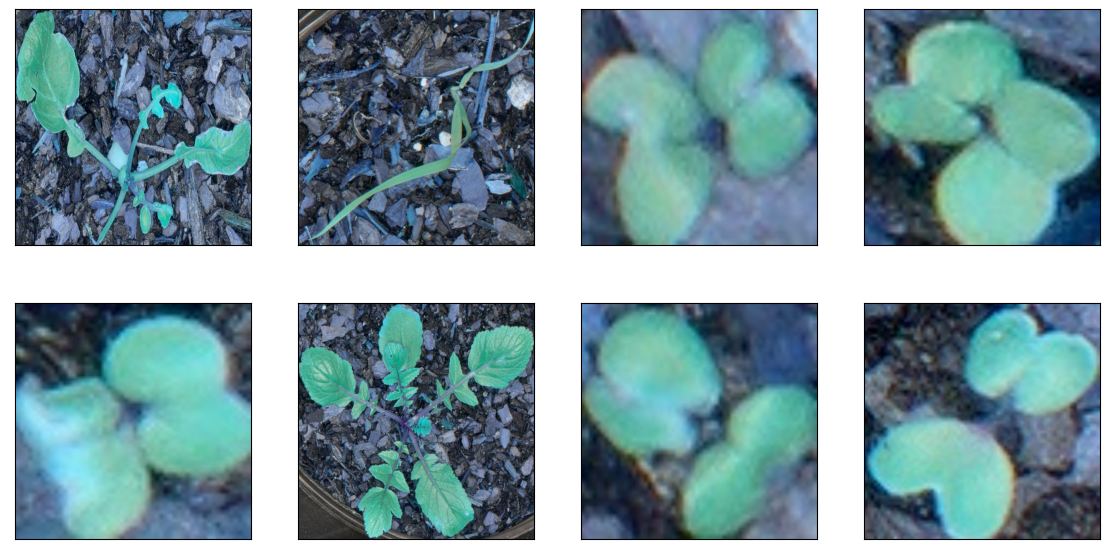

In [7]:
# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [ ]:
for rgb_img in imgs:
    rgb_img[rgb_img == 0] = np.nan
    means = np.nanmean(rgb_img[:, 1:], axis=1)

In [46]:
from math import sqrt

img = imgs[0]
b, g, r = cv2.split(img)
# mean = r.sum() / r.size

mean = np.mean(r, dtype = np.float32)

std = np.std(r, dtype = np.float32)
mean

140.46037

In [61]:
import numpy.ma as ma

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float64)
# mask_copy = rgb_img.copy()
# ignore_zeros = True
# c = ma.masked_where(rgb_img == [0,0,0], rgb_img, copy=True)
# rgb_img = ma.array(rgb_img, mask=c)
# for ch in cv2.split(rgb_img):
    # print(np.mean(ch))

# rgb_img[rgb_img == [0,0,0]] = np.nan
rgb_img[rgb_img == 0] = np.nan
# np.mean(rgb_img)
# np.nanmean(rgb_img)
rgb_channels = cv2.split(rgb_img)
for c in rgb_channels:
    print(pd.DataFrame(c.flatten()).describe())

                   0
count  127955.000000
mean      182.156977
std        17.590495
min         1.000000
25%       174.000000
50%       185.000000
75%       194.000000
max       255.000000
                  0
count  127969.00000
mean      200.77221
std        16.71502
min        33.00000
25%       196.00000
50%       204.00000
75%       211.00000
max       255.00000
                   0
count  107446.000000
mean       56.170188
std        31.955941
min         1.000000
25%        33.000000
50%        60.000000
75%        80.000000
max       255.000000


In [48]:
import numpy.ma as ma

img = imgs[0]

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float64)
ignore_zeros = False

if ignore_zeros:
#     # Mask out zero values for descriptive stats
    rgb_img[rgb_img == 0] = np.nan

rgb_channels = cv2.split(rgb_img)
str_channels = ["r", "g", "b"]
desc_stats = dict()
for img_c, str_c in zip(rgb_channels, str_channels):
    # img_c = img_c.astype(np.float64)
    rec_key = f"channel_{str_c}"
    
    c_df = pd.DataFrame(img_c.flatten(), columns=[rec_key]).describe()
    
    c_scipy_desc = stats.describe(img_c.flatten(), nan_policy='omit')
    
    c_df.loc["variance"] = c_scipy_desc.variance
    c_df.loc["skewness"] = c_scipy_desc.skewness
    c_df.loc["kurtosis"] = c_scipy_desc.kurtosis
    desc_stats.update(c_df.to_dict())

desc_stats

{'channel_r': {'count': 283398.0,
  'mean': 82.24439128010783,
  'std': 91.41654493261647,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.0,
  '75%': 183.0,
  'max': 255.0,
  'variance': 8356.984687417089,
  'skewness': 0.2400031480729161,
  'kurtosis': -1.8920048512717056},
 'channel_g': {'count': 283398.0,
  'mean': 90.65914014918948,
  'std': 100.54327919855234,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.0,
  '75%': 202.0,
  'max': 255.0,
  'variance': 10108.950991998048,
  'skewness': 0.22579297643910887,
  'kurtosis': -1.918489337152128},
 'channel_b': {'count': 283398.0,
  'mean': 21.29606419240785,
  'std': 33.61320420202762,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.0,
  '75%': 45.0,
  'max': 255.0,
  'variance': 1129.8474967272068,
  'skewness': 1.3205129296283729,
  'kurtosis': 0.680378400600826}}

In [99]:
desc_stats

{'channel_r': {'count': 5270.0,
  'mean': 154.54117647058823,
  'std': 56.210100147980704,
  'min': 0.0,
  '25%': 119.0,
  '50%': 177.0,
  '75%': 194.0,
  'max': 255.0,
  'variance': 3159.5753586460205,
  'skewness': -0.983650690616091,
  'kurtosis': -0.26793575475401266},
 'channel_g': {'count': 5270.0,
  'mean': 159.29620493358632,
  'std': 64.55796029936627,
  'min': 0.0,
  '25%': 110.0,
  '50%': 189.0,
  '75%': 210.0,
  'max': 255.0,
  'variance': 4167.730238014551,
  'skewness': -0.890640763247287,
  'kurtosis': -0.5941403926352211},
 'channel_b': {'count': 5270.0,
  'mean': 95.01442125237192,
  'std': 38.21460240246249,
  'min': 0.0,
  '25%': 72.0,
  '50%': 102.0,
  '75%': 124.0,
  'max': 201.0,
  'variance': 1460.3558367782916,
  'skewness': -0.6041498038556853,
  'kurtosis': -0.16954033907267085}}